In [425]:
# Built-in dependencies
from typing import Optional, Type
from abc import ABC, abstractmethod

# External dependencies
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# LinearRegression Interface

In [361]:
class LinearRegression(ABC):
    """
    Linear Regression Model interface.
    """

    def __init__(self, X: np.ndarray, y: np.ndarray, add_constant: bool = True) -> None:
        """
        Initializes the regression model.
        
        Parameters:
            X (np.ndarray): Design matrix (n_samples x n_features).
            y (np.ndarray): Response variable (n_samples x 1).
            add_constant (bool): Whether to add a constant column to X for the intercept term.
        """

        self.y = y
        self.X = X if not add_constant else self.add_constant(X=X)
        
        self.beta: Optional[np.ndarray] = None

        return
    
    @staticmethod
    def add_constant(X: np.ndarray) -> np.ndarray:
        """
        Adds a constant column to the design matrix for the intercept term.
        
        Parameters:
            X (np.ndarray): Design matrix (n_samples x n_features).
        
        Returns:
            np.ndarray: Augmented design matrix with an intercept column.
        """
        return np.hstack((np.ones((X.shape[0], 1)), X))

    @abstractmethod
    def fit(self) -> None:
        """
        Computes the regression coefficients. Must be implemented by subclasses.
        """
        raise NotImplementedError

    def predict(self, X: np.ndarray) -> np.ndarray:
        """
        Predicts response values for new data.
        
        Parameters:
            X (np.ndarray): New data for prediction.
        
        Returns:
            np.ndarray: Predicted values.
        """
        
        if X.shape[1] + 1 == self.X.shape[1]:
            X = self.add_constant(X=X)

        return X @ self.beta

# GLS LinearRegression Implementation

In [399]:
class GLS(LinearRegression):
    """
    Generalized Least Squares Regression Model.
    Handles heteroskedasticity and autocorrelation in residuals by incorporating the residual covariance matrix (omega).
    """
    
    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        omega: Optional[np.ndarray] = None
    ) -> None:
        """
        Initializes the GLS model.
        
        Parameters:
            X (np.ndarray): Design matrix (n_samples x n_features).
            y (np.ndarray): Response variable (n_samples x 1).
            omega (Optional[np.ndarray]): Covariance matrix of residuals (n_samples x n_samples). Defaults to None (OLS case).
        """

        self.omega: np.ndarray = self._calculate_omega(y=y, omega=omega)

        super().__init__(X=X, y=y)

        return

    @staticmethod
    def _calculate_omega(y: np.ndarray, omega: Optional[np.ndarray]) -> np.ndarray:
        """
        Calculates the residual covariance matrix (omega).
        
        Parameters:
            omega (Optional[np.ndarray]): Covariance matrix of residuals or None.
        
        Returns:
            np.ndarray: Valid covariance matrix (n_samples x n_samples).
        """
        return omega if omega is not None else np.eye(len(y))

    def fit(self) -> None:
        """
        Fits the GLS model using the generalized normal equation: (X'W^(-1)X)^(-1)X'W^(-1)y.
        """

        # Store the inverse of the residual covariance matrix to optimize latency and avoid inverting the matrix twice 
        omega_inverse: np.ndarray = np.linalg.inv(a=self.omega)

        # Solve the GLS equation
        self.beta: np.ndarray = np.linalg.solve(a=self.X.T @ omega_inverse @ self.X, b=self.X.T @ omega_inverse @ self.y)

        return

In [400]:
y_train = np.random.randn(1_000, 1)
X_train = np.random.randn(1_000, 10)

y_test = np.random.randn(1_000, 1)
X_test = np.random.randn(1_000, 10)

gls: GLS = GLS(X=X_train, y=y_test)
gls.fit()

y_hat = gls.predict(X=X_test)

np.var(y_hat - y_test, ddof=1)

0.9978086612706463

# OLS LinearRegression Implementation 

In [401]:
class OLS(GLS):
    """
    Ordinary Least Squares Regression Model.
    Inherits from LinearRegression and implements its methods.
    """
    
    def __init__(self, X: np.ndarray, y: np.ndarray) -> None:
        """
        Initializes the OLS model.
        
        Parameters:
            X (np.ndarray): Design matrix (n_samples x n_features).
            y (np.ndarray): Response variable (n_samples x 1).
        """

        super().__init__(X=X, y=y, omega=None)
        
        return

Test

In [402]:
y_train = np.random.randn(1_000, 1)
X_train = np.random.randn(1_000, 10)

y_test = np.random.randn(1_000, 1)
X_test = np.random.randn(1_000, 10)

ols: OLS = OLS(X=X_train, y=y_test)
ols.fit()

y_hat = ols.predict(X=X_test)

np.var(y_hat - y_test, ddof=1)

1.1094809390875895

# WLS LinearRegression Implementation

In [414]:
class WLS(GLS):
    """
    Weighted Least Squares Regression Model.
    Extends GLS for cases where omega is diagonal and weights are derived from residuals or provided.
    """
    
    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        weights: Optional[np.ndarray] = None
    ) -> None:
        """
        Initialize the WLS model.
        
        Parameters:
            X (np.ndarray): Design matrix (n_samples x n_features).
            y (np.ndarray): Response variable (n_samples x 1).
            weights (Optional[np.ndarray]): Diagonal weights (1 / variance for each observation). If None, computes weights as the inverse of squared OLS residuals.
        """
        
        self.weights: np.ndarray = self._calculate_weights(X=X, y=y, weights=weights)
        
        # Call the parent class to initialize with the computed diagonal omega matrix
        super().__init__(X=X, y=y, omega=self._calculate_diagonal_omega(weights=self.weights))

        return

    @staticmethod
    def _calculate_weights(X: np.ndarray, y: np.ndarray, weights: Optional[np.ndarray]) -> np.ndarray:
        """
        Calculate weights for the WLS model.
        
        If weights are provided, returns the flattened version of the weights.
        If weights are None, calculates weights as the inverse of squared residuals from an OLS model fitted on the provided data.
        
        Parameters:
            X (np.ndarray): Design matrix (n_samples x n_features).
            y (np.ndarray): Response variable (n_samples x 1).
            weights (Optional[np.ndarray]): Provided weights (1 / variance for each observation) or None.

        Returns:
            np.ndarray: Calculated weights (n_samples,).
        """

        if weights is None:
        
            # Fit an OLS model
            ols: OLS = OLS(X=X, y=y)
            ols.fit()
            
            # Compute OLS residuals
            residuals: np.ndarray = y - ols.predict(X=X)

            # Compute weights as inverse of squared residuals (variance estimators)
            return 1 / (residuals.flatten() ** 2)
        
        # Use provided weights
        return weights.flatten()
    
    @staticmethod
    def _calculate_diagonal_omega(weights: np.ndarray) -> np.ndarray:
        """
        Construct the diagonal covariance matrix (omega) based on the weights.
        
        This method creates a diagonal matrix where each diagonal entry corresponds 
        to the inverse of the provided weights.
        
        Parameters:
            weights (np.ndarray): Calculated weights (n_samples,).
        
        Returns:
            np.ndarray: Diagonal covariance matrix (n_samples x n_samples).
        """
        return np.diag(1 / weights)


In [415]:
y_train = np.random.randn(1_000, 1)
X_train = np.random.randn(1_000, 10)

y_test = np.random.randn(1_000, 1)
X_test = np.random.randn(1_000, 10)

wls: WLS = WLS(X=X_train, y=y_test)
wls.fit()

y_hat = wls.predict(X=X_test)

np.var(y_hat - y_test, ddof=1)

0.9989847736197438

In [417]:
weights: np.ndarray = np.square(np.random.randn(1_000, 1))
wls: WLS = WLS(X=X_train, y=y_test, weights=weights)
wls.fit()

y_hat = wls.predict(X=X_test)

np.var(y_hat - y_test, ddof=1)

1.0309086613635607

# Cross-Sectional WLS Asset Pricing / Risk Model Example

In [418]:
np.random.seed(42)

# Number of stocks
n_stocks = 100  

# Number of risk factors (e.g., beta, size, value)
n_factors = 3   

# Number of industry dummies
n_industries = 5

Observable factor loadings

In [419]:
# Generate risk factors
risk_factor_loadings = np.random.randn(n_stocks, n_factors)

# Generate industry dummies
industries = np.random.randint(0, n_industries, size=n_stocks)
industry_dummy_loadings = np.eye(n_industries)[industries]

# Combine risk factors and industry dummies to create the design matrix
X = np.hstack((risk_factor_loadings, industry_dummy_loadings))
X

array([[ 0.49671415, -0.1382643 ,  0.64768854,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [ 1.52302986, -0.23415337, -0.23413696,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ],
       [ 1.57921282,  0.76743473, -0.46947439,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ],
       [ 0.54256004, -0.46341769, -0.46572975,  0.        ,  0.        ,
         0.        ,  0.        ,  1.        ],
       [ 0.24196227, -1.91328024, -1.72491783,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.56228753, -1.01283112,  0.31424733,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [-0.90802408, -1.4123037 ,  1.46564877,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ],
       [-0.2257763 ,  0.0675282 , -1.42474819,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ],
       [-0.54438272,  0.11092259

True factor returns

In [420]:
# Risk factor returns / beta coefficients
true_fundamental_factor_returns = np.array([0.02, -0.01, 0.03]) 

# True industry returns / beta coefficients
industry_factor_returns = np.random.uniform(-0.05, 0.05, size=n_industries)  

# Combine risk and industry factor effects
true_risk_factor_returns = np.hstack((true_fundamental_factor_returns, industry_factor_returns))
true_risk_factor_returns

array([ 0.02      , -0.01      ,  0.03      , -0.03811821, -0.03824738,
        0.01492103,  0.02460449,  0.00833688])

Stock returns with heteroskedastic residuals

In [421]:
# Simulated market capitalization
stock_market_cap = np.random.uniform(1, 100, size=n_stocks)  

# Simualte heteroskedasticity via the empirical relationship that larger stocks have lower variance
residual_variance = 1 / stock_market_cap
residuals = np.random.randn(n_stocks) * np.sqrt(residual_variance)

# Simulate stock returns
y = X @ true_risk_factor_returns + residuals
y

array([ 0.10051114, -0.23450249, -0.24707364, -0.20878919, -0.12190357,
        0.0963283 ,  1.01394552, -0.02548974,  0.68732338, -0.17958523,
       -0.30252436, -0.06324232,  0.14179691, -0.04080021, -0.24527992,
       -0.02846133, -0.11479793,  0.05941003,  0.00206467, -0.13664211,
       -0.08329908, -0.14099841, -0.019018  ,  0.22247861, -0.18111938,
        0.02186716, -0.03836366, -0.09895753,  0.00458419, -0.24454196,
       -0.09472427, -0.22162973,  0.22160644,  0.03340549, -0.04994225,
        0.03092308, -0.10332951,  0.05105186,  0.10961352,  0.08655237,
        0.02763984, -0.14556138, -0.01535822, -0.2311239 , -0.20065848,
        0.21392316,  0.25311036, -0.02860418,  0.02828493,  0.0190373 ,
        1.25853235,  0.53125942, -0.062087  , -0.0511838 , -0.08646503,
        0.11631531, -0.10692693, -0.21898928, -0.10623758,  0.02017913,
        0.13492816,  0.12311248, -0.05468737,  0.30381229,  0.0139751 ,
       -0.0630548 ,  0.20040406,  0.0476504 , -0.14474001,  0.05

Fit WLS to create a BLUE estimator in the presence of heteroskedasticity

In [422]:
risk_model_ols: OLS = OLS(X=X, y=y)
risk_model_ols.fit()

risk_model_wls: WLS = WLS(X=X, y=y)
risk_model_wls.fit()

In [423]:
y_hat_ols: np.ndarray = risk_model_ols.predict(X=X)
y_hat_wls: np.ndarray = risk_model_wls.predict(X=X)

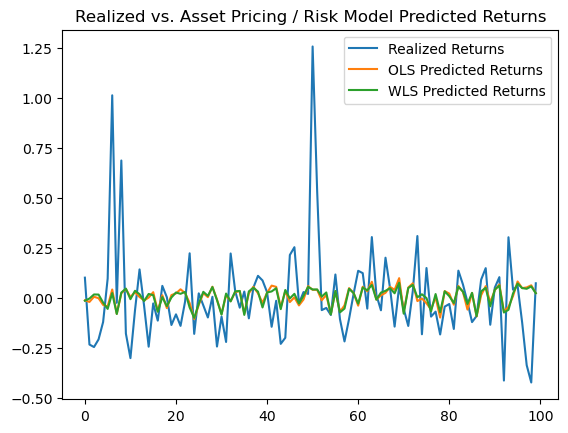

In [424]:
pd.DataFrame({"Realized Returns": y, "OLS Predicted Returns": y_hat_ols, "WLS Predicted Returns": y_hat_wls}).plot(title="Realized vs. Asset Pricing / Risk Model Predicted Returns")
plt.show()

In [450]:
class PanelRegression:
    """
    Panel Regression Model for time-series cross-sectional data.
    Executes a user-specified regression model (e.g., GLS) for each time step.
    """

    def __init__(
        self,
        X: np.ndarray,
        y: np.ndarray,
        model: Type[GLS] = GLS,
        add_constant: bool = True,
        omega: Optional[np.ndarray] = None
    ) -> None:
        """
        Initialize the PanelRegression object.

        Parameters:
            X (np.ndarray): Design matrix of shape (n_samples, n_features, n_time_steps).
            y (np.ndarray): Response variable of shape (n_samples, 1, n_time_steps).
            model (Type[GLS]): Regression model to use (e.g., GLS).
            add_constant (bool): Whether to add a constant column to X for the intercept term.
            omega (Optional[np.ndarray]): Covariance matrix of residuals (n_samples x n_samples x n_time_steps). Defaults to None (OLS case).
        """

        self.X = X
        self.y = y
        self.model = model
        self.omega = omega

        # Preallocate coefficients array for all time steps
        self.beta: np.ndarray = np.zeros((self.X.shape[1] + 1, self.X.shape[2])) if add_constant else np.zeros((self.X.shape[1], self.X.shape[2]))

        return

    def fit(self) -> None:
        """
        Fit the panel regression model across all time steps.

        For each time step, the specified regression model is instantiated, fitted, and
        the coefficients are stored.

        Returns:
            None
        """

        for t in range(self.X.shape[2]):
            
            X_t = self.X[:, :, t]
            y_t = self.y[:, :, t].flatten()
            omega = None if self.omega is None else self.omega[:, :, t]

            print(X_t.shape)
            print(y_t.shape)

            # Fit the model and store coefficients
            model_instance = self.model(X=X_t, y=y_t, omega=omega)
            model_instance.fit()
            self.beta[:, t] = model_instance.beta.flatten()

        return

In [456]:
import numpy as np

np.random.seed(42)

# Number of stocks, factors, industries, and time steps
n_stocks = 100
n_factors = 3
n_industries = 5
n_time_steps = 15

# Generate risk factor loadings
risk_factor_loadings = np.random.randn(n_stocks, n_factors, n_time_steps)

# Generate industry dummies (time-invariant)
industries = np.random.randint(0, n_industries, size=n_stocks)
industry_dummy_loadings = np.eye(n_industries)[industries]
industry_dummy_loadings = np.repeat(industry_dummy_loadings[:, :, None], n_time_steps, axis=2)

# Combine risk factors and industry dummies into the design matrix
X = np.concatenate((risk_factor_loadings, industry_dummy_loadings), axis=1)

# True factor returns (time-varying for risk factors and industry returns)
true_factor_returns = np.random.uniform(-0.05, 0.05, size=(n_factors + n_industries, n_time_steps))

# Simulated market capitalization (time-invariant)
stock_market_cap = np.random.uniform(1, 100, size=n_stocks)

# Simulate heteroskedasticity: residual variance inversely proportional to market cap
residual_variance = 1 / stock_market_cap
residuals = np.random.randn(n_stocks, 1, n_time_steps) * np.sqrt(residual_variance[:, None, None])

# Simulate stock returns sequentially
y = np.zeros((n_stocks, 1, n_time_steps))

# Dot product for time step `t`
for t in range(n_time_steps):
   y[:, 0, t] = X[:, :, t] @ true_factor_returns[:, t]
    
# Add residuals
y += residuals


In [457]:
panel = PanelRegression(X=X, y=y, model=GLS)
panel.fit()
panel.beta

(100, 8)
(100,)
(100, 8)
(100,)
(100, 8)
(100,)
(100, 8)
(100,)
(100, 8)
(100,)
(100, 8)
(100,)
(100, 8)
(100,)
(100, 8)
(100,)


LinAlgError: Singular matrix

<Axes: >

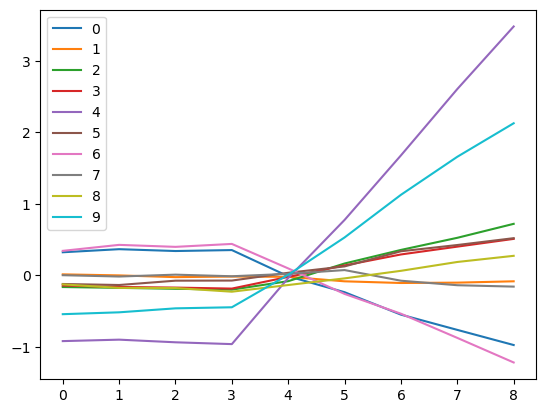

In [455]:
pd.DataFrame(panel.beta).cumsum().plot()